# Titanic: Machine Learning from Disaster

[*Clique aqui*](https://www.kaggle.com/c/titanic/) *para o link da competição no [Kaggle](kaggle.com)*

---

Este é um dos desafios de *Machine Learning* mais famosos, promovida pelo site (kaggle.com)[kaggle.com], uma plataforma de competições de análise preditiva. Sua popularidade fez com que virasse um **Hello, World!** de Ciência de Dados.


## 1. Definição do problema 

Apesar dos sobreviventes contarem com a sorte, alguns fatores influenciaram algumas pessoas a terem mais ou menos chances de sobreviverem, como sexo e idade ("Mulheres e crianças primeiro!").


### Objetivo

O objetivo é prever, com base nos regressores, construir um modelo para prever se a pessoa sobreviveria ou não ao acidente trágico. A pontuação será feita exclusivamente pela acurácia, isto é, pelo percentual de acertos em relação ao total.

## 2. Obtenção dos dados

Os dados estão disponíveis no Kaggle, e estão divididos em dois grupos:
* Dataset de treino (`train.csv`)
    * Deve ser usado para criar e treinar o modelo de *Machine Learning*
    * Possui como linhas os passageiros do Titanic, e como colunas várias informações sobre cada passageiro
    * Diz se a pessoa sobreviveu ou não
* Dataset de teste (`test.csv`)
    * Deve ser usado como dados nunca vistos pelo modelo
    
Está disponível também um gabarito de como devem ser feitas as submissões (`gender_submission.csv`). 

Para baixar os dados, é necessário ter uma conta no Kaggle. Após isso, é só extrair os arquivos na pasta desejada, de preferência uma de fácil acesso.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# allow showing all columns
pd.options.display.max_columns = None

# seed for random states
SEED = 357 # inside joke

# magical commands for plotting
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [50]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

In [3]:
print(f"Number of values for training: {train.shape[0]}")

Number of values for training: 891


## 3. Explorando os Dados

Serão estuda

### Dicionário de Dados

* PassengerId: Número de identificação do passageiro
* Survived: Informa se o passageiro sobreviveu ao desastre
    * 0 = Não
    * 1 = Sim
* Pclass: Classe do bilhete
    * 1 = 1ª Classe
    * 2 = 2ª Classe
    * 3 = 3ª Classe
* Name: Nome do passageiro
* Sex: Sexo do passageiro
* Age: Idade do passageiro
* SibSp: Quantidade de cônjuges e irmãos a bordo
* Parch: Quantidade de pais e filhos a bordo
* Ticket: Número da passagem
* Fare: Preço da Passagem
* Cabin: Número da cabine do passageiro
* Embarked: Porto no qual o passageiro embarcou
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton

In [4]:
def concat_df(train_data, test_data):
    """Returns a concatenated DataFrame of training and test set"""
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    """Returns divided DataFrames of training and test set"""
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [5]:
df_all = concat_df(train, test)
df_all.sample(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
595,36.00,NaN,S,24.1500,"Van Impe, Mr. Jean Baptiste",1,596,3,male,1,0.0,345773
1019,42.00,NaN,S,13.0000,"Bowenur, Mr. Solomon",0,1020,2,male,0,NaN,211535
1079,NaN,NaN,S,69.5500,"Sage, Miss. Ada",2,1080,3,female,8,NaN,CA. 2343
469,0.75,NaN,C,19.2583,"Baclini, Miss. Helene Barbara",1,470,3,female,2,1.0,2666
155,51.00,NaN,C,61.3792,"Williams, Mr. Charles Duane",1,156,1,male,0,0.0,PC 17597


In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [7]:
def display_missing(df):
    """Displays missing value for each column of the DataFrame"""
    for col in df.columns.tolist():          
        print(f'\t{col} column missing values: {df[col].isnull().sum()}')
        
        
print('Missing values in set:')
display_missing(df_all)

Missing values in set:
	Age column missing values: 263
	Cabin column missing values: 1014
	Embarked column missing values: 2
	Fare column missing values: 1
	Name column missing values: 0
	Parch column missing values: 0
	PassengerId column missing values: 0
	Pclass column missing values: 0
	Sex column missing values: 0
	SibSp column missing values: 0
	Survived column missing values: 418
	Ticket column missing values: 0


In [8]:
(df_all.isnull().sum() / df_all.shape[0]).sort_values(ascending=False)

Cabin          0.774637
Survived       0.319328
Age            0.200917
Embarked       0.001528
Fare           0.000764
Ticket         0.000000
SibSp          0.000000
Sex            0.000000
Pclass         0.000000
PassengerId    0.000000
Parch          0.000000
Name           0.000000
dtype: float64

In [11]:
df_all.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


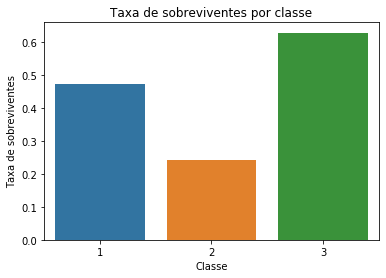

In [16]:
sns.barplot(df_all['Pclass'].unique().astype(str),
            df_all.groupby(['Pclass'])['Survived'].mean())
plt.xlabel("Classe")
plt.ylabel("Taxa de sobreviventes")
plt.title("Taxa de sobreviventes por classe")
plt.show()

## 4. Preparação dos dados

### Preenchendo NAs

Como o sexo e a classe parecem ser variáveis importantes, preencheremos os *NA*s de idade com a mediana de cada sexo de acordo com a sua classe no navio.

In [20]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print(f'Median age of Pclass {pclass} {sex}s: {age_by_pclass_sex[sex][pclass]}')
print(f'Median age of all passengers: {df_all["Age"].median()}')

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


O padrão para variáveis categóricas é preencher os *NA*s com a moda, isto é, o valor mais comum dos dados.

In [21]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [22]:
# Filling the missing values in Embarked with the mode
mode_embarked = df_all['Embarked'].mode().values[0]
print(f'The mode, i.e. the most common value, in "Embaked", is {mode_embarked}')
df_all['Embarked'].fillna(mode_embarked, inplace=True)

The mode, i.e. the most common value, in "Embaked", is S


Preencheremos o valor do bilhete com o preço mediano para homens solteiros desacompanhados da 3ª classe

In [23]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [24]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]

df_all['Fare'].fillna(med_fare, inplace=True)

print(f"Median fare paid by lone travelers of 3rd class: {med_fare}")

Median fare paid by lone travelers of 3rd class: 7.8542


In [25]:
df_all.isnull().any()

Age            False
Cabin           True
Embarked       False
Fare           False
Name           False
Parch          False
PassengerId    False
Pclass         False
Sex            False
SibSp          False
Survived        True
Ticket         False
dtype: bool

Não iremos preencher os *NA*s nas cabines pois estes dados não nos interessam para esta análise

### Porto de embarque

Conforme vemos acima, o local de embarque parece um aspecto importante para a sobrevivência dos passageiros. Como os algoritmos apenas suportam valores numéricos, vamos então criar variáveis *dummy*. O que são variáveis *dummy*? São variáveis que utilizam apenas um valor de $0$ ou $1$ para indicar se é ou não alguma coisa. Exemplificando, a variável *dummy* (ou binária) ```Embarked_S``` terá valor 1 se o passageiro embarcou ou Southampton e valor 0 caso se embarcou em outro porto. 

O problema é que, quando geramos $n$ variáveis binárias para $n$ categorias geramos uma multicolinearidade entre os regressores. Para evitar isso, podemos gerar apenas $n-1$ variáveis, com a última sendo implícita.

In [26]:
df_all['Embarked_S'] = (df_all['Embarked'] == 'S').astype(int)
df_all['Embarked_C'] = (df_all['Embarked'] == 'C').astype(int)

df_all.sample(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_S,Embarked_C
358,22.00,NaN,Q,7.8792,"McGovern, Miss. Mary",0,359,3,female,0,1.0,330931,0,0
78,0.83,NaN,S,29.0000,"Caldwell, Master. Alden Gates",2,79,2,male,0,1.0,248738,1,0
298,42.00,C106,S,30.5000,"Saalfeld, Mr. Adolphe",0,299,1,male,0,1.0,19988,1,0
843,34.50,NaN,C,6.4375,"Lemberopolous, Mr. Peter L",0,844,3,male,0,0.0,2683,0,1
751,6.00,E121,S,12.4750,"Moor, Master. Meier",1,752,3,male,0,1.0,392096,1,0


### Sexo

Iremos gerar uma variável binária de forma similar ao que fizemos com o porto de embarque

In [27]:
def transform_sex(valor):
    """changes categorical value of sex to a binary numerical value of sex"""
    return 1 if valor == 'female' else 0

In [28]:
df_all['Sex_binary'] = df_all['Sex'].map(transform_sex)

### Títulos

Haviam a bordo militares, nobres, senhoras e senhores. Os seus títulos estão junto com os seus nomes. Podemos verificar qual a frequência dos títulos utilizando **expressões regulares**.

In [29]:
df_all['Titles'] = df_all['Name'].str.extract("([A-z]+)\\.")

df_all.sample(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_S,Embarked_C,Sex_binary,Titles
735,28.5,NaN,S,16.1000,"Williams, Mr. Leslie",0,736,3,male,0,0.0,54636,1,0,0,Mr
966,32.5,C132,C,211.5000,"Keeping, Mr. Edwin",0,967,1,male,0,NaN,113503,0,1,0,Mr
789,46.0,B82 B84,C,79.2000,"Guggenheim, Mr. Benjamin",0,790,1,male,0,0.0,PC 17593,0,1,0,Mr
279,35.0,NaN,S,20.2500,"Abbott, Mrs. Stanton (Rosa Hunt)",1,280,3,female,1,1.0,C.A. 2673,1,0,1,Mrs
558,39.0,E67,S,79.6500,"Taussig, Mrs. Emil (Tillie Mandelbaum)",1,559,1,female,1,1.0,110413,1,0,1,Mrs
316,24.0,NaN,S,26.0000,"Kantor, Mrs. Sinai (Miriam Sternin)",0,317,2,female,1,1.0,244367,1,0,1,Mrs
561,40.0,NaN,S,7.8958,"Sivic, Mr. Husein",0,562,3,male,0,0.0,349251,1,0,0,Mr
339,45.0,T,S,35.5000,"Blackwell, Mr. Stephen Weart",0,340,1,male,0,0.0,113784,1,0,0,Mr
154,25.0,NaN,S,7.3125,"Olsen, Mr. Ole Martin",0,155,3,male,0,0.0,Fa 265302,1,0,0,Mr
519,32.0,NaN,S,7.8958,"Pavlovic, Mr. Stefo",0,520,3,male,0,0.0,349242,1,0,0,Mr


Funcionou! Agora podemos plotar para verificar a frequência de cada título

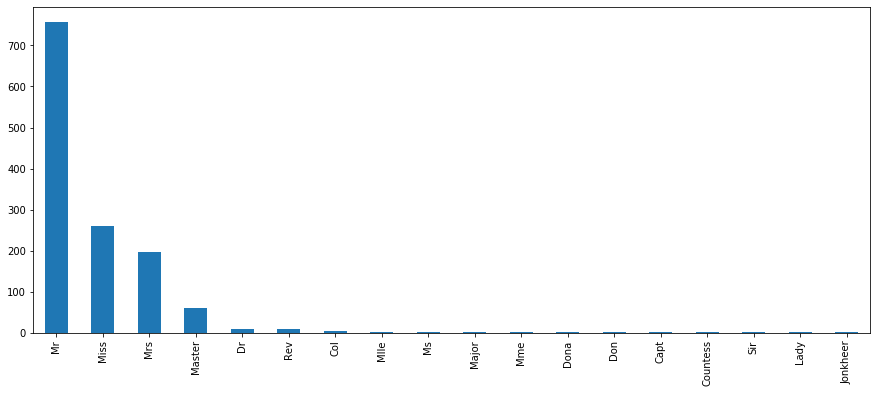

In [30]:
fig, ax = plt.subplots(figsize=(15, 6))

df_all['Titles'].value_counts().plot(ax=ax, kind='bar')

Podemos agrupar estes vários títulos menores. 

*Capt* e *Col* são abreviações de Capitão e Coronel. Podemos juntá-los com Major sob o título 'Militar'.

Quanto aos títulos femininos, *Mlle* é a versão francesa de *Miss*, que é aplicado a mulheres solteiras, ao passo que *Mme*, também francês e quivalente a *Mrs*, é aplicado a mulheres casadas. Já *Ms* não indica estado civil, e devido à sua baixa ocorrência seria interessante agrupá-lo em alguma categoria mais frequente. Vejamos:

In [31]:
df_all[df_all['Titles'] == 'Ms']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_S,Embarked_C,Sex_binary,Titles
443,28.0,NaN,S,13.00,"Reynaldo, Ms. Encarnacion",0,444,2,female,0,1.0,230434,1,0,1,Ms
979,22.0,NaN,Q,7.75,"O'Donoghue, Ms. Bridget",0,980,3,female,0,NaN,364856,0,0,1,Ms


Ambas são passageiras sem parentes ou familiares a bordo, então não custa nada assumir que se tratam de duas mulheres solteiras. Podemos, assim, substituir pelo título de *Miss* 

Por último, *Countess*, *Don*, *Dona*, *Lady*, *Sir* e *Jonkheer* (título da nobreza dos Países Baixos) podem ser agrupados como 'Nobreza'.

In [32]:
def group_titles(title):
    if title in ['Capt', 'Col', 'Major']:
        return 'Military'
    
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    
    elif title in ['Mme']:
        return 'Mrs'
    
    elif title in ["Countess", "Don", "Dona", "Lady", "Sir", "Jonkheer"]:
        return 'Nobility'
    else:
        return title

In [33]:
df_all['Titles'] = df_all['Titles'].map(group_titles)

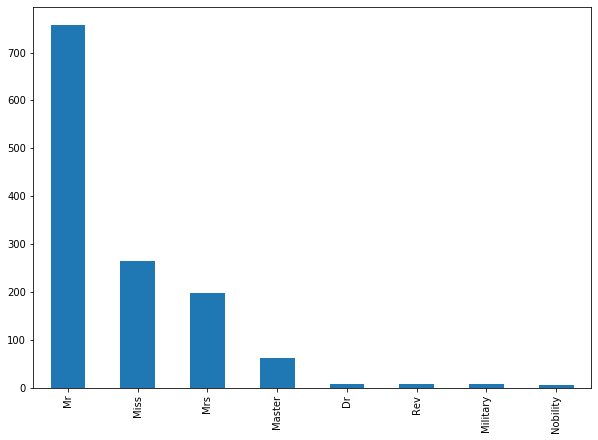

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))

df_all['Titles'].value_counts().plot(ax=ax, kind='bar')

Agora só precisamos gerar as variáveis binárias. Existe uma função do Pandas que nos permite fazer isso automaticamente, o ```pd.get_dummies```. Porém, ele gera $n$ variáveis, então iremos excluir a última para evitar multicolinearidade.

In [35]:
df_all = pd.get_dummies(df_all,
                        prefix="Titles",
                        columns=['Titles'])

df_all.drop('Titles_Rev',
            axis=1,
            inplace=True)
df_all.sample(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_S,Embarked_C,Sex_binary,Titles_Dr,Titles_Master,Titles_Military,Titles_Miss,Titles_Mr,Titles_Mrs,Titles_Nobility
1279,21.0,NaN,Q,7.7500,"Canavan, Mr. Patrick",0,1280,3,male,0,NaN,364858,0,0,0,0,0,0,0,1,0,0
410,25.0,NaN,S,7.8958,"Sdycoff, Mr. Todor",0,411,3,male,0,0.0,349222,1,0,0,0,0,0,0,1,0,0
68,17.0,NaN,S,7.9250,"Andersson, Miss. Erna Alexandra",2,69,3,female,4,1.0,3101281,1,0,1,0,0,0,1,0,0,0
313,28.0,NaN,S,7.8958,"Hendekovic, Mr. Ignjac",0,314,3,male,0,0.0,349243,1,0,0,0,0,0,0,1,0,0
855,18.0,NaN,S,9.3500,"Aks, Mrs. Sam (Leah Rosen)",1,856,3,female,0,1.0,392091,1,0,1,0,0,0,0,0,1,0


In [63]:
train, test = divide_df(df_all)

In [64]:
variables = [
    'Sex_binary', 'Age', 'Pclass','SibSp', 'Parch', 'Fare','Embarked_S', 'Embarked_C', 
    'Titles_Dr', 'Titles_Master', 'Titles_Military', 'Titles_Miss', 'Titles_Mr', 'Titles_Mrs', 'Titles_Nobility'
]

X = train[variables]
y = train['Survived']

# 5. Construção do Modelo

## Modelo com RandomForest

In [38]:
results_rf = []
kf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=SEED)

for lines_train, lines_valid in kf.split(X):
    X_train, X_valid = X.iloc[lines_train], X.iloc[lines_valid]
    y_train, y_valid = y.iloc[lines_train], y.iloc[lines_valid]

    model = RandomForestClassifier(criterion='gini',
                                   n_estimators=2000,
                                   max_depth=7,
                                   min_samples_split=6,
                                   min_samples_leaf=6,
                                   max_features='auto',
                                   oob_score=True,
                                   n_jobs=-1,
                                   random_state=SEED)
    model.fit(X_train, y_train)

    p = model.predict(X_valid)

    acc = np.mean(y_valid == p)
    results_rf.append(acc)
    print(f"Acc: {acc}")
    print()

Acc: 0.8385650224215246

Acc: 0.8067415730337079

Acc: 0.8475336322869955

Acc: 0.7865168539325843

Acc: 0.8295964125560538

Acc: 0.8134831460674158

Acc: 0.8251121076233184

Acc: 0.7865168539325843

Acc: 0.8026905829596412

Acc: 0.8292134831460675

Acc: 0.8318385650224215

Acc: 0.8314606741573034

Acc: 0.8071748878923767

Acc: 0.8179775280898877

Acc: 0.8161434977578476

Acc: 0.8269662921348314

Acc: 0.8161434977578476

Acc: 0.8179775280898877

Acc: 0.827354260089686

Acc: 0.8157303370786517



In [39]:
np.mean(results_rf)

0.8187368368015318

(array([2., 0., 1., 2., 4., 2., 4., 3., 1., 1.]),
 array([0.78651685, 0.79261853, 0.79872021, 0.80482189, 0.81092357,
        0.81702524, 0.82312692, 0.8292286 , 0.83533028, 0.84143195,
        0.84753363]),
 <a list of 10 Patch objects>)

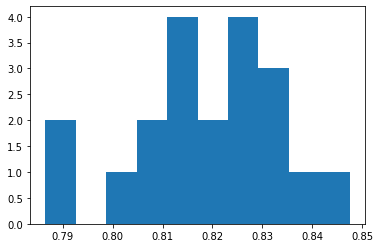

In [40]:
pylab.hist(results_rf)

## Modelo com LogisticRegression

In [41]:
results_lr = []
kf = RepeatedKFold(n_splits=2, n_repeats=20, random_state=SEED)

for linhas_treino, linhas_valid in kf.split(X):
    
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]
    
    model = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=SEED)
    model.fit(X_treino, y_treino)
    
    p = model.predict(X_valid)
    
    acc = np.mean(y_valid == p)
    results_lr.append(acc)
    print(f'Acc: {acc}')
    print()

Acc: 0.8385650224215246

Acc: 0.8067415730337079

Acc: 0.8340807174887892

Acc: 0.8067415730337079

Acc: 0.8251121076233184

Acc: 0.8292134831460675

Acc: 0.8139013452914798

Acc: 0.8179775280898877

Acc: 0.8094170403587444

Acc: 0.8337078651685393

Acc: 0.8228699551569507

Acc: 0.8292134831460675

Acc: 0.820627802690583

Acc: 0.8067415730337079

Acc: 0.8251121076233184

Acc: 0.8404494382022472

Acc: 0.8071748878923767

Acc: 0.8089887640449438

Acc: 0.8228699551569507

Acc: 0.8134831460674158

Acc: 0.8139013452914798

Acc: 0.8179775280898877

Acc: 0.8116591928251121

Acc: 0.8269662921348314

Acc: 0.8071748878923767

Acc: 0.8247191011235955

Acc: 0.8094170403587444

Acc: 0.8471910112359551

Acc: 0.8295964125560538

Acc: 0.8134831460674158

Acc: 0.8139013452914798

Acc: 0.8314606741573034

Acc: 0.820627802690583

Acc: 0.8089887640449438

Acc: 0.8183856502242153

Acc: 0.8269662921348314

Acc: 0.8139013452914798

Acc: 0.8179775280898877

Acc: 0.8295964125560538

Acc: 0.8382022471910112



In [42]:
?LogisticRegression

## Comparação dos dois modelos

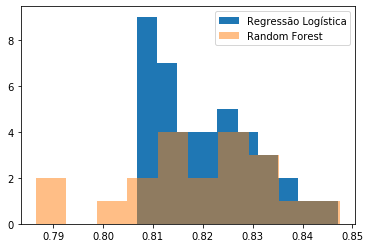

In [43]:
pylab.hist(results_lr)
pylab.hist(results_rf, alpha=0.5)

plt.legend(labels = ['Regressão Logística', 'Random Forest'])

In [74]:
means = [np.mean(results_rf), np.mean(results_lr)]

for i in range(2):
    print(f'Mean of model #{i+1}: {means[i]}')

Mean of model #1: 0.8187368368015318
Mean of model #2: 0.8208770846979393


In [76]:
maxes = [np.max(results_rf), np.max(results_lr)]

for i in range(2):
    print(f'Max of model #{i+1}: {maxes[i]}')

Max of model #1: 0.8475336322869955
Max of model #2: 0.8471910112359551


In [68]:
model_rf = RandomForestClassifier(criterion='gini',
                                  n_estimators=2250,
                                  max_depth=8,
                                  min_samples_split=6,
                                  min_samples_leaf=6,
                                  max_features='auto',
                                  oob_score=True,
                                  n_jobs=-1,
                                  random_state=SEED)
model_rf.fit(X, y)

p = model_rf.predict(test[variables])
p = p.astype(int)

# 6. Submissão ao Kaggle

In [70]:
sub = pd.Series(p, index=test['PassengerId'], name='Survived')
sub.shape

(418,)

In [71]:
sub.to_csv('model_with_random_forest.csv', header=True)

In [49]:
!head -n10 model_with_random_forest.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
